In [1]:
import numpy as np
import cv2
import os
import time
from datetime import datetime
import matplotlib.pyplot as plt

print("OpenCV:", cv2.__version__)

OpenCV: 4.4.0


In [19]:
url = 0 # La webcam propia
url = "http://24.103.196.243/cgi-bin/viewer/video.jpg" # una calle
url = "http://12.216.61.98:82/mjpg/video.mjpg" # Perretes
url = "http://46.84.170.81/videostream.cgi?user=admin&pwd=" # Vacas
url = "http://207.199.201.177/mjpg/video.mjpg" # Caballo
#url = "http://77.243.103.105:8081/mjpg/video.mjpg" # Tienda
url = "http://166.247.40.112:82/mjpg/video.mjpg" # Calle con coches

# Comprobar camara

In [20]:
cap = cv2.VideoCapture(url)

while(True):
    ret, frame = cap.read()

    cv2.imshow('frame', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

In [5]:
cap = cv2.VideoCapture(url)

ok, first_frame = cap.read()

while(1):
    ok, frame = cap.read()
    diff = cv2.absdiff(first_frame, frame)

    cv2.imshow('first_frame',first_frame)
    cv2.imshow('frame', frame)
    cv2.imshow('diff', diff)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

# Obtener fondo por la Media
As long as a pixel is not covered by a moving object more than 50% of the time, the median of the pixel will give a good estimate of the background at that pixel.

In [12]:
# Open Video
cap = cv2.VideoCapture(url)

# Store selected frames in an array
frames = []
bg = None

count = 10
while(True):
    ret, frame = cap.read()
    frames.append(frame)

    # Calculate the median along the time axis
    if count==10:
        bg = np.median(frames, axis=0).astype(dtype=np.uint8)
        count=0
        print("actualizo")
    count+=1
    
    cv2.imshow('frame', frame)
    cv2.imshow('median', bg)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

actualizo
actualizo
actualizo
actualizo
actualizo
actualizo
actualizo


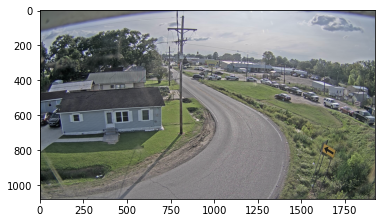

In [13]:
plt.imshow(bg[:,:,::-1])

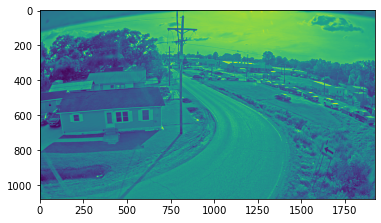

In [16]:
bg_grey = cv2.cvtColor(bg, cv2.COLOR_BGR2GRAY)
plt.imshow(bg_grey)

# Manual Substraction (of background)

In [17]:
cap = cv2.VideoCapture(url)
 
while(True):
    ok, frame = cap.read()
    
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    diff = cv2.absdiff(bg_grey, frame_gray)
    
    ret,mask = cv2.threshold(diff,20,255,cv2.THRESH_BINARY)
    fg = cv2.bitwise_and(frame,frame,mask = mask)
    

    cv2.imshow('bg', bg)
    cv2.imshow('frame', frame_gray)
    cv2.imshow('diff', diff)
    cv2.imshow('mask', fg)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

# By running mean

In [4]:
c = cv2.VideoCapture(url)
_,f = c.read()

avg1 = np.float32(f)
avg2 = np.float32(f)

while(1):
    _,f = c.read()

    cv2.accumulateWeighted(f,avg1,0.1)
    cv2.accumulateWeighted(f,avg2,0.01)

    res1 = cv2.convertScaleAbs(avg1)
    res2 = cv2.convertScaleAbs(avg2)

    cv2.imshow('img',f)
    cv2.imshow('avg1',res1)
    cv2.imshow('avg2',res2)

    if cv2.waitKey(0):
        break

cv2.destroyAllWindows()
c.release()

# BackgroundSubtractorMOG2

In [18]:
cap = cv2.VideoCapture(url)

#fgbg = cv2.createBackgroundSubtractorMOG2(history=20, varThreshold=25, detectShadows=True)
fgbg = cv2.createBackgroundSubtractorMOG2(history=20, varThreshold=25, detectShadows=True)

while(1):
    ret, frame = cap.read()

    fgmask = fgbg.apply(frame)
    bgmask = cv2.bitwise_not(fgmask)
    
    fg = cv2.bitwise_and(frame,frame,mask = fgmask)
    bg = cv2.bitwise_and(frame,frame,mask = bgmask)

    cv2.imshow('foregroug',fg)
    cv2.imshow('backgroug',bg)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

In [21]:
cap = cv2.VideoCapture(url)

# params for ShiTomasi corner detection
feature_params = dict( maxCorners = 100,
                       qualityLevel = 0.3,
                       minDistance = 7,
                       blockSize = 7 )

# Parameters for lucas kanade optical flow
lk_params = dict( winSize  = (15,15),
                  maxLevel = 2,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# Create some random colors
color = np.random.randint(0,255,(100,3))

# Take first frame and find corners in it
ret, old_frame = cap.read()
old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
p0 = cv2.goodFeaturesToTrack(old_gray, mask = None, **feature_params)

# Create a mask image for drawing purposes
mask = np.zeros_like(old_frame)

while(1):
    ret,frame = cap.read()
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # calculate optical flow
    p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)

    # Select good points
    good_new = p1[st==1]
    good_old = p0[st==1]

    # draw the tracks
    for i,(new,old) in enumerate(zip(good_new,good_old)):
        a,b = new.ravel()
        c,d = old.ravel()
        mask = cv2.line(mask, (a,b),(c,d), color[i].tolist(), 2)
        frame = cv2.circle(frame,(a,b),5,color[i].tolist(),-1)
    img = cv2.add(frame,mask)

    cv2.imshow('frame',img)
    k = cv2.waitKey(30) & 0xff
    if k == 27:
        break

    # Now update the previous frame and previous points
    old_gray = frame_gray.copy()
    p0 = good_new.reshape(-1,1,2)

cv2.destroyAllWindows()
cap.release()

<ipython-input-21-670177be56e5>:40: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  mask = cv2.line(mask, (a,b),(c,d), color[i].tolist(), 2)
<ipython-input-21-670177be56e5>:41: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  frame = cv2.circle(frame,(a,b),5,color[i].tolist(),-1)


In [22]:
cap = cv2.VideoCapture(url)

ret, frame1 = cap.read()
prvs = cv2.cvtColor(frame1,cv2.COLOR_BGR2GRAY)
hsv = np.zeros_like(frame1)
hsv[...,1] = 255

while(1):
    ret, frame2 = cap.read()
    next = cv2.cvtColor(frame2,cv2.COLOR_BGR2GRAY)

    flow = cv2.calcOpticalFlowFarneback(prvs,next, None, 0.5, 3, 15, 3, 5, 1.2, 0)

    mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
    hsv[...,0] = ang*180/np.pi/2
    hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
    rgb = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)

    cv2.imshow('frame2',rgb)
    k = cv2.waitKey(30) & 0xff
    if k == 27:
        break
    elif k == ord('s'):
        cv2.imwrite('opticalfb.png',frame2)
        cv2.imwrite('opticalhsv.png',rgb)
    prvs = next

cap.release()
cv2.destroyAllWindows()